In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import math
import glob

In [7]:
#UNZIPPING THE DATASET
!unzip /content/brain_tumor_dataset.zip

Archive:  /content/brain_tumor_dataset.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: B

In [8]:
#Count the no. of images in the respective classes 0 - Brain Tumour and 1 - Healthy Brain
ROOT_DIR = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))


In [9]:
number_of_images.items()

dict_items([('Healthy', 2087), ('Brain Tumor', 2513)])

**WE WILL SPLIT THE DATA INTO THE FOLLOWING MANNER:-**


*   70% TRAINING DATA
*   15% VALIDATION DATA
*   15% TESTING DATA

In [10]:
#Creating a train folder

def dataFolder(p, split):

  if not os.path.exists("./" + p):
    os.mkdir("./" + p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                  size = (math.floor(split*number_of_images[dir])-5),
                                  replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+p, dir)
        shutil.copy(O, D)
        os.remove(O)
  else:
    print(f"{p} folder exists.")

In [11]:
dataFolder("train",0.7)

In [12]:
dataFolder("val",0.15)

In [13]:
dataFolder("test",0.15)

In [14]:
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Healthy', 16), ('Brain Tumor', 17)])

**PREPARING OUR DATA USING DATA GENERATOR**

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [16]:
def preprocessingImages1(path):
  """
  input : Path
  output : Pre processed images
  """

  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2,preprocessing_function= preprocess_input, horizontal_flip= True) #data augmentation
  image = image_data.flow_from_directory(directory= path, target_size= (224, 224), batch_size = 32, class_mode= 'binary')

  return image

In [17]:
path = '/content/train'
train_data = preprocessingImages1(path)

Found 3209 images belonging to 2 classes.


In [18]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [19]:
def preprocessingImages2(path):
  """
  input : Path
  output : Pre processed images
  """

  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory= path, target_size= (224, 224), batch_size = 32, class_mode= 'binary')

  return image

In [20]:
path = '/content/test'
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [21]:
path = '/content/val'
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


**MODEL TRAINING**

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import keras

In [23]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
for layer in base_model.layers:
  layer.trainable = False

In [25]:
X = Flatten()(base_model.output)
X = Dense(units= 1, activation= 'sigmoid')(X)

model = Model(base_model.input, X)

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [27]:
model.compile(optimizer= 'rmsprop', loss= keras.losses.binary_crossentropy, metrics= ['accuracy'])

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# EARLYSTOPPING
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1)

# MODEL CHECKPOINT
mc = ModelCheckpoint(monitor = 'val_accuracy',filepath = '/content/bestmodel.keras', save_best_only = True, verbose = 1)

cd = [mc,es]

In [30]:
hist = model.fit(train_data,
               steps_per_epoch = 8,
               epochs = 30,
               validation_data = val_data,
               validation_steps = 16,
               callbacks = cd)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5190 - loss: 7.9229
Epoch 1: val_accuracy improved from -inf to 0.59570, saving model to /content/bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.5230 - loss: 7.9060 - val_accuracy: 0.5957 - val_loss: 5.8868
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7661 - loss: 2.5556
Epoch 2: val_accuracy improved from 0.59570 to 0.88623, saving model to /content/bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7704 - loss: 2.5041 - val_accuracy: 0.8862 - val_loss: 0.7041
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8817 - loss: 0.6822
Epoch 3: val_accuracy did not improve from 0.88623
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8792 - loss: 0.6953 - val_accuracy: 0.8613 - val_loss: 0.8097
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8569 - loss: 0.5997
Epoch 4: val_accuracy did not improve from 0.88623
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accur

In [31]:
model = load_model('/content/bestmodel.keras')

In [32]:
acc = model.evaluate(test_data)[1]

print(f"The accuracy of the model is {acc*100} %")

22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9327 - loss: 0.3437
The accuracy of the model is 93.22533011436462 %


In [33]:
h = hist.history

h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

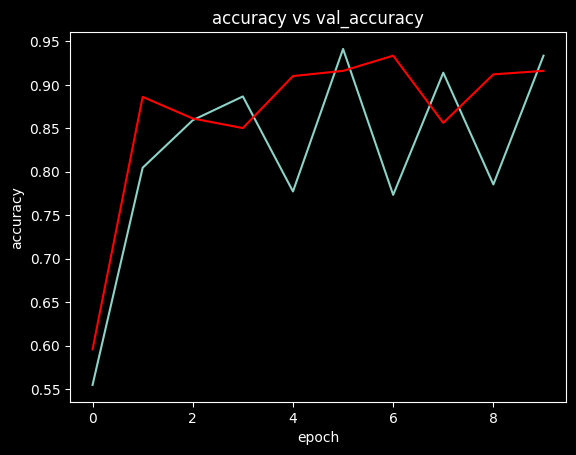

In [35]:
plt.style.use('dark_background')

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title("accuracy vs val_accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

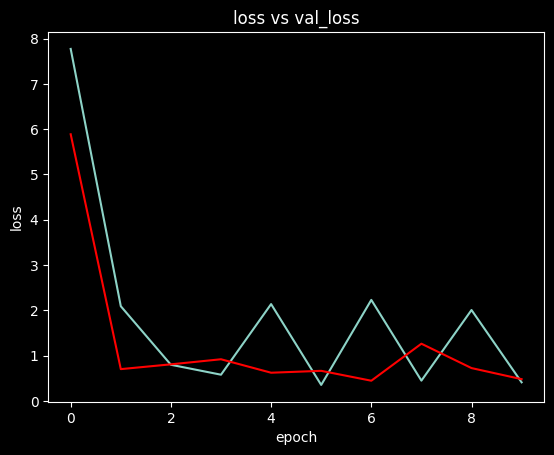

In [36]:
plt.style.use('dark_background')

plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title("loss vs val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


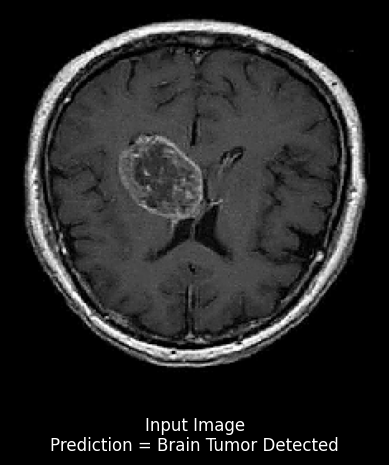

In [47]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

# LOAD THE PRE-TRAINED MODEL
model = load_model("/content/bestmodel.keras")

# LOAD AND PREPROCESS THE IMAGE
path = "/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1872).jpg"
img = image.load_img(path, target_size=(224, 224))
i = image.img_to_array(img) / 255.0  # NORMALIZE IMAGE
input_arr = np.expand_dims(i, axis=0)  # RESHAPE TO MATCH INPUT FORMAT

# MAKE PREDICTION
pred = model.predict(input_arr)

# DISPLAY THE IMAGE
plt.imshow(i)
plt.axis('off')

# ADD PREDICTION TEXT
if pred[0][0] <= 0.5:  # ADJUST THE THRESHOLD OR INDEX BASED ON MODEL'S OUTPUT
    prediction_text = "Prediction = Brain Tumor Detected"
else:
    prediction_text = "Prediction = No Brain Tumor Detected"

# ADD THE TEXT BELOW THE IMAGE
plt.text(
    0.5, -0.1,  # POSITION THE TEXT BELOW THE IMAGE
    f"Input Image\n{prediction_text}",
    fontsize=12,
    ha='center',  # HORIZONTAL ALIGNMENT
    va='top',  # VERTICAL ALIGNMENT
    transform=plt.gca().transAxes  # USE AXIS COORDINATES FOR PLACEMENT
)

plt.show()
